In [1]:
'''This example demonstrates the use of Convolution1D for text classification.
Gets to 0.89 test accuracy after 2 epochs.
90s/epoch on Intel i5 2.4Ghz CPU.
10s/epoch on Tesla K40 GPU.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot
%matplotlib inline  

In [3]:
# set parameters:
max_features = 50
maxlen = 100
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 100
epochs = 6

#### Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

#### As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

In [8]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


In [9]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))


In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
## We use only 1000 samples to save computation time
model_training=model.fit(x_train[0:3000], y_train[0:3000],
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test[0:3000], y_test[0:3000]))

Train on 3000 samples, validate on 3000 samples
Epoch 1/6
3000/3000 [==============================] - 13s 4ms/step - loss: 0.6655 - acc: 0.5973 - val_loss: 0.6591 - val_acc: 0.6063
Epoch 2/6
3000/3000 [==============================] - 13s 4ms/step - loss: 0.6517 - acc: 0.6230 - val_loss: 0.6751 - val_acc: 0.5890
Epoch 3/6
3000/3000 [==============================] - 13s 4ms/step - loss: 0.6417 - acc: 0.6290 - val_loss: 0.6523 - val_acc: 0.6167
Epoch 4/6
3000/3000 [==============================] - 13s 4ms/step - loss: 0.6271 - acc: 0.6510 - val_loss: 0.6502 - val_acc: 0.6163
Epoch 5/6
3000/3000 [==============================] - 13s 4ms/step - loss: 0.6143 - acc: 0.6557 - val_loss: 0.6491 - val_acc: 0.6227
Epoch 6/6
3000/3000 [==============================] - 13s 4ms/step - loss: 0.6024 - acc: 0.6787 - val_loss: 0.6513 - val_acc: 0.6227


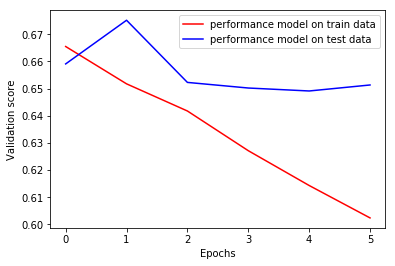

In [16]:
# Create the plot
pyplot.plot(model_training.history['loss'], 'r',label='performance model on train data')
pyplot.plot(model_training.history['val_loss'], 'b',label='performance model on test data')
pyplot.xlabel('Epochs')
pyplot.ylabel('Validation score')
pyplot.legend()
pyplot.show()

## We seem to be improving our prediction ability using our train data but our performance with the test data is stalling!!! (we are overfitting)
### Clear indication that we have to further improve our network.
### Try using more nodes (e.g. 250)
### try using all the training data (25000)

In [21]:
# Create confusion matrix for 1000 reviews in the test set
reviews=pd.DataFrame()
reviews['actual']=y_test[0:10000]
reviews['predicted']=model.predict(x_test[0:10000]).round()


In [20]:
pd.crosstab(reviews['actual'], reviews['predicted'], rownames=['Actual Types'], colnames=['Predicted Types'])

Predicted Types,0.0,1.0
Actual Types,,
0,296,230
1,141,333
